## Enviroment: 
Open AI gym [MountainCarContinuous-v0](https://github.com/openai/gym/wiki/MountainCarContinuous-v0)

### Observation
Type: Box(2)

| Num  | Observation | Min   | Max  |
| ---- | ----------- | ----- | ---- |
| 0    | position    | -1.2  | 0.6  |
| 1    | velocity    | -0.07 | 0.07 |

### Actions

Type: Discrete(3)

| Num  | Action     |
| ---- | ---------- |
| 0    | Push car to the left (negative value) or to the right (positive value |

### Reward

Reward is 100 for reaching the target of the hill on the right hand side, minus the squared sum of actions from start to goal.

This reward function raises an exploration challenge, because if the agent does not reach the target soon enough, it will figure out that it is better not to move, and won't find the target anymore.

Note that this reward is unusual with respect to most published work, where the goal was to reach the target as fast as possible, hence favouring a bang-bang strategy.

### Starting State

Position equal to 0.5. A constraint on velocity might be added in a more challenging version.

Adding a maximum number of steps might be a good idea.

### Episode Termination

The episode ends when you reach 0.5 position, or if 200 iterations are reached.

### Solved Requirements
Get a reward over 90. This value might be tuned.


## 1. gym enviroment setup

In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

env = gym.make("MountainCarContinuous-v0")
env.reset()

array([-0.49057207,  0.        ])

## 2. Q Table setup

As action is an continue value 
we should build an discrete action spaces for the environment

In [2]:
LEARNING_RATE = 0.5
DISCOUNT = 0.95
EPISODES = 10000
SHOW_EVERY = 200
Q_TABLE_LEN = 200

In [3]:
action_space = np.array(range(-10,11,4))/10.
action_space = action_space.reshape(len(action_space),1) #to fit with the enviroment

DISCRETE_OS_SIZE = [Q_TABLE_LEN] * len(env.observation_space.high)
discrete_os_win_size = (env.observation_space.high - env.observation_space.low) / DISCRETE_OS_SIZE

q_table = np.random.uniform(low=0, high=1,
                            size=(DISCRETE_OS_SIZE + [len(action_space)]))

# q_table = np.zeros(DISCRETE_OS_SIZE + [len(action_space)])

In [20]:
q_table.shape , action_space.shape

((200, 200, 6), (6, 1))

### Decay epsilon 

In [5]:
epsilon = 1  # not a constant, qoing to be decayed
START_EPSILON_DECAYING = 1
END_EPSILON_DECAYING = EPISODES//2
epsilon_decay_value = epsilon/(END_EPSILON_DECAYING - START_EPSILON_DECAYING)

## 3. Help functions 

**action_indx** and **action** value correspond to **Q[state][action_indx]** and **action**

In [9]:
def get_discrete_state (state):
    discrete_state = (state - env.observation_space.low) // discrete_os_win_size
    return tuple(discrete_state.astype(int))

def take_epilon_greedy_action(state, epsilon):
    discrete_state = get_discrete_state(state)
    if np.random.random() < epsilon:
        action_indx = np.random.randint(0,len(action_space))
    else:
        action_indx = np.argmax(q_table[discrete_state])
    return action_indx, action_space[action_indx]

## 4. Rewards Recorder setup 

In [10]:
ep_rewards = []
aggr_ep_rewards = {'ep':[],'avg':[],'min':[],'max':[]}

## 5. Train the Agent 
Different from "MountainCar-v0" action_indx and action in action_space are added

In [11]:
for episode in range(EPISODES):
    # initiate reward every episode
    ep_reward = 0
    if episode % SHOW_EVERY == 0:
        print("episode: {}".format(episode))
        render = True
    else:
        render = False

    state = env.reset()
    done = False
    while not done:
        action_indx, action = take_epilon_greedy_action(state, epsilon)

        next_state, reward, done, _ = env.step(action)

        ep_reward += reward

        # if render:
        #     env.render()

        if not done:

            td_target = reward + DISCOUNT * np.max(q_table[get_discrete_state(next_state)])

            q_table[get_discrete_state(state)][action_indx] += LEARNING_RATE * (td_target - q_table[get_discrete_state(state)][action_indx])

        elif next_state[0] >= 0.5:
            # print("I made it on episode: {} Reward: {}".format(episode,reward))
            q_table[get_discrete_state(state)][action_indx] = 0


        state = next_state

    # Decaying is being done every episode if episode number is within decaying range
    if END_EPSILON_DECAYING >= episode >= START_EPSILON_DECAYING:
        epsilon -= epsilon_decay_value

    # recoard aggrated rewards on each epsoide
    ep_rewards.append(ep_reward)

    # every SHOW_EVERY calculate average rewords
    if episode % SHOW_EVERY == 0:
        avg_reward = sum(ep_rewards[-SHOW_EVERY:]) / len(ep_rewards[-SHOW_EVERY:])
        aggr_ep_rewards['ep'].append(episode)
        aggr_ep_rewards['avg'].append(avg_reward)
        aggr_ep_rewards['min'].append(min(ep_rewards[-SHOW_EVERY:]))
        aggr_ep_rewards['max'].append(max(ep_rewards[-SHOW_EVERY:]))

episode: 0
episode: 200
episode: 400
episode: 600
episode: 800
episode: 1000
episode: 1200
episode: 1400
episode: 1600
episode: 1800
episode: 2000
episode: 2200
episode: 2400
episode: 2600
episode: 2800
episode: 3000
episode: 3200
episode: 3400
episode: 3600
episode: 3800
episode: 4000
episode: 4200
episode: 4400
episode: 4600
episode: 4800
episode: 5000
episode: 5200
episode: 5400
episode: 5600
episode: 5800
episode: 6000
episode: 6200
episode: 6400
episode: 6600
episode: 6800
episode: 7000
episode: 7200
episode: 7400
episode: 7600
episode: 7800
episode: 8000
episode: 8200
episode: 8400
episode: 8600
episode: 8800
episode: 9000
episode: 9200
episode: 9400
episode: 9600
episode: 9800


Text(0, 0.5, 'Rewards')

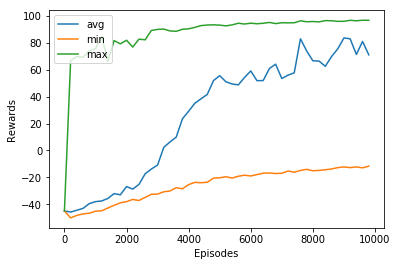

In [12]:
plt.plot(aggr_ep_rewards['ep'], aggr_ep_rewards['avg'], label = 'avg')
plt.plot(aggr_ep_rewards['ep'], aggr_ep_rewards['min'], label = 'min')
plt.plot(aggr_ep_rewards['ep'], aggr_ep_rewards['max'], label = 'max')
plt.legend(loc='upper left')
plt.xlabel('Episodes')
plt.ylabel('Rewards')

### 6. Rendering Test

In [17]:
done = False
state = env.reset()
while not done:
    action_indx = np.argmax(q_table[get_discrete_state(state)])
    next_state, _, done, _ = env.step(action_space[action_indx])
    state = next_state
    env.render()

env.close()